In [1]:
import numpy as np
from numpy.random import choice as np_choice
from __future__ import division
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
pool_size = multiprocessing.cpu_count()

In [18]:
# This implementation has been inspired by Lab 5 and 
# N. K. Singh and S. Baidya, 
# "A novel work for bin packing problem by ant colony optimization," 
# International Journal of Research in Engineering and Technology (IJRET), vol. 2, Special Issue 2, pp. 71–73, Dec. 2013. [

class AntColony(object):
    """
    Implement ACO (Ant Colony Optimization) algorithm.
    """

    def __init__(self, num_items, items, capacity, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Initialize ACO instance.
        
        :param num_items: Number of items to be added to bins.
        :param items: Specifies the item sizes to be added to bins.
        :param capacity: Total capacity of one bin.
        :param n_ants: Number of ants running per iteration
        :param n_best: Number of best ants who deposit pheromone.
        :param decay: Rate at which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to slow decay, 0.5 to much faster decay.
        :param alpha: exponent on pheromone, higher alpha gives pheromone more weight. Default=1
        :param beta: exponent on load capacity, higher beta gives load capacity more weight. Default=1

        """
        self.num_items = num_items
        self.items = items
        self.capacity = capacity
        self.pheromone = np.ones((self.num_items, self.num_items))

        self.all_inds = range(num_items)
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        
        self.all_time_best = None
        self.best_bins_history = []
        self.final_loads = []

    def run(self, rng = None):
        """
        Runs the ACO algorithm.
        """
        if rng is None:
            rng = np.random

        shortest_path = None
        self.all_time_best = ("placeholder", np.inf)

        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths(rng)
            self.spread_pheromone(all_paths)
            shortest_path = min(all_paths, key=lambda x: x[1])

            if shortest_path[1] < self.all_time_best[1]:
                self.all_time_best = shortest_path
            
            self.best_bins_history.append(self.all_time_best[1])
            self.final_loads = self.all_time_best[2]
            self.pheromone = self.pheromone * self.decay
            
    
    def gen_path(self, rng=None):
        """
        Generates a single ant's path through the items for the bin packaging problem. 

        :return path: Sequence of (current_item, next_item) representing the ant's path.
        :return num_bins: Number of bins needed for the ant's path.
        :return bin_weights: The total weight of items in each bin.
        """

        if rng is None:
            rng = np.random

        remaining_items = set(range(self.num_items)) # Remaining items contains all items initially
        path = [] # Stores edges showing path links between items
        num_bins = 0 # Number of bins
        bin_weights = [] # Weights of items in bins

        while remaining_items:
            num_bins += 1 # Increase bin number
            current_weight = 0 # Initially bin is empty
            current_bin = [] # Initially bin is empty

            
            feasible = [i for i in remaining_items if self.items[i] <= self.capacity] # Select feasible items for this bin
            
            # If no feasible items, move to the next bin
            if not feasible:
                break

            
            
            current = rng.choice(feasible)
            # current = np_choice(feasible) # Pick a feasible item
            remaining_items.remove(current) # Remove picked item from remaining items 
            current_bin.append(current) # Add picked item to the current bin
            current_weight += self.items[current] # Add item size to the weight of the current bin

            # Keep adding items until bin is full
            while True:
                
                feasible = [j for j in remaining_items if current_weight + self.items[j] <= self.capacity]

                if not feasible:
                    break

                probs = []
                for j in feasible:
                    # Pheromone value
                    if not current_bin:
                        tau_bj = 1
                    else:
                        tau_bj = sum(self.pheromone[j, i] for i in current_bin) / len(current_bin)

                    
                    eta_j = (self.capacity - (current_weight + self.items[j])+1e-6) / self.capacity # Heuristic desirability (how well the item fits)

                    # Probability of adding this item
                    probs.append((tau_bj ** self.alpha) * (eta_j ** self.beta))
                
               
                probs = np.array(probs) / np.sum(probs) # Probabilities
                #next_item = np_choice(feasible, p=probs) # Pick next item
                next_item = rng.choice(feasible, p=probs)


                path.append((current, next_item)) # Add edge between current and next item in path

                current_bin.append(next_item) # Add next item to current bin
                remaining_items.remove(next_item) # Remove next item from remaining items
                current_weight += self.items[next_item] # Add next item to the weight of the current bin
                current = next_item # Set current to next item 

            bin_weights.append(current_weight) # Append total weight of current bin to bin weights

        return path, num_bins, bin_weights


    def gen_all_paths(self, rng = None):
        """
        Generating all paths for all ants.

        :return all_paths: Contains path, number of bins, and bin weights for all ants.
        """
        if rng is None:
            rng = np.random

        all_paths = []
        for i in range(self.n_ants):
            path, num_bins, bin_weight = self.gen_path()
            all_paths.append((path, num_bins, bin_weight))
        return all_paths
    
    def fitness(self, num_bins, bin_weights):
        """
        Used to update pheromones. Shows the amount of pheromones a single ant deposits. Based on function shown in referenced paper.

        :param num_bins: Number of bins in path.
        :param bin_weights: Total weights for bins in path.

        :return the amount of pheromones a single ant deposits.

        """

        
        m = 2
        return (1 / num_bins) * sum((w / self.capacity) ** m for w in bin_weights)

    def spread_pheromone(self, all_paths):
        """
        Spreads pheromones for all paths.

        :param all_paths: Contains paths, number of bins and bin weights for all ants.
        """

        for path, num_bins, bin_weights in all_paths[:self.n_best]:
            delta_tau = self.fitness(num_bins, bin_weights)
            for bin_items in path:  
                for i in bin_items:
                    for j in bin_items:
                        if i != j:
                            self.pheromone[i,j] += delta_tau
    


# Running the ACO algorithm.

The algorithm will be ran on 8 problems selected from the Data/1_D Bin Packing folder

In [3]:
# Function to read a local bin packing instance

def read_binpack_file(filename):
    """
    Reads a 1-D bin packing instance from a local text file.
    
    File format:
    Line 1: Number of items (n)
    Line 2: Box capacity (C)
    Line 3: Item sizes separated by spaces
    
    Returns:
    - num_items: int
    - box_capacity: int
    - items: list of ints
    """
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    test_problems = lines[0]
    instances = {}
    i = 1
    while i < len(lines):
        if "u" in lines[i] or "t" in lines[i]:
            id = lines[i]
            i+=1
            bin_capacity, num_items, best_known_bins = lines[i].split()
            
            i+=1
            item_sizes = [float(lines[i + j].strip()) for j in range(int(num_items))]
            i += int(num_items)
            instances[id] = {
                "bin_capacity": int(float(bin_capacity)),
                "num_items": int(num_items),
                "best_known_bins": int(best_known_bins),
                "item_sizes": item_sizes
            }
    return instances

In [4]:
# Helper function to for parallel execution

def run_aco(aco, seed):
    """
    Runs an ACO instance with a given random seed. 
    Used for parallel execution.

    :param pso: PSO instance.
    :param seed: Seed for random generator for ensuring reproducibility.
    
    :return: PSO instance after execution.
    """

    rng = np.random.RandomState(seed)
    aco.run(rng)
    return aco

## Problem #1

In [5]:
# Get the data


filename = "Data/1-D Bin Packing /binpack1.txt"

problems = read_binpack_file(filename)

## Select one problem from the instance

first_problem_key = list(problems.keys())[0]

capacity = problems[first_problem_key]["bin_capacity"]
num_items = problems[first_problem_key]["num_items"]
item_sizes = problems[first_problem_key]["item_sizes"]

print("Capacity: ", capacity)
print("Number of items: ", num_items)

Capacity:  150
Number of items:  120


Mean number of final bins 53.6
Median number of final bins 54.0
Best number of final bins 53
Worst number of final bins 54
Standard deviation 0.48989794855663565


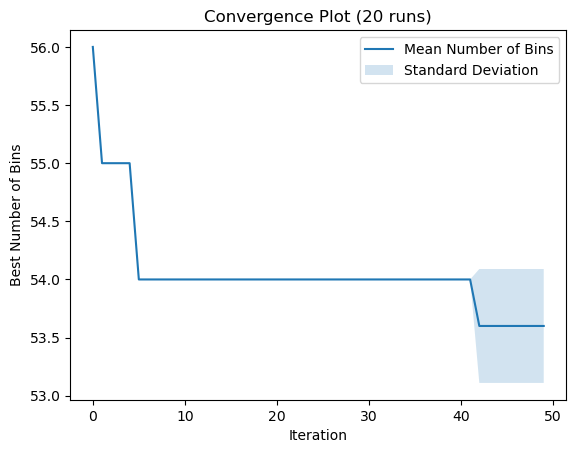

Mean number of unused capacity  962.0
Median number of unused capacity 1022.0
Best number of unused capacity 872.0
Worst number of unused capacity 1022.0
Standard deviation of unused capacity 73.48469228349535


Load Distributiom for the best solution
The unused capacity for best solution 872.0


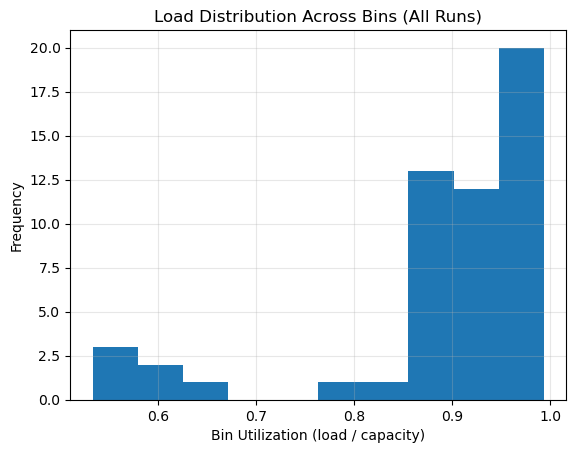

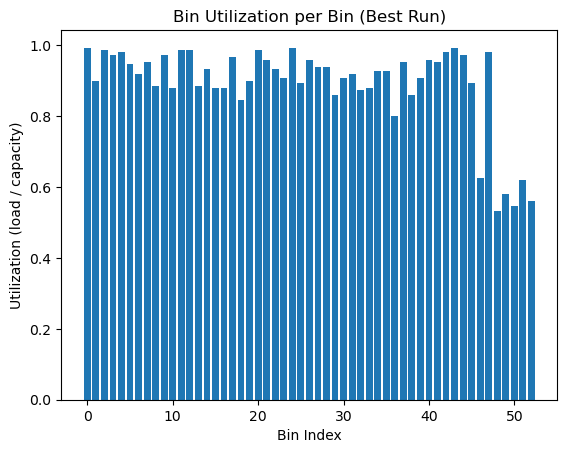

In [44]:

# Aggregate results over 20 runs

n_runs = 20 # Number of runs
results = [] # Used for parallel execution

all_runs = [] # Results for each run

with multiprocessing.Pool(processes=pool_size) as pool:
    for run in range(n_runs):
        
        random.seed(run)

        aco = AntColony(num_items=num_items, capacity=capacity, items=item_sizes, n_ants=5, n_best = 5, n_iterations=50, decay = 0.9, alpha = 1, beta = 1)
        res = pool.apply_async(run_aco, (aco,run,))
        results.append(res)
    for result in [res.get() for res in results]:
        run_result = {
            'best_solution': result.all_time_best,
            'best_bins_history': np.array(result.best_bins_history),
            'final_loads': result.final_loads
                                    }
        all_runs.append(run_result)

# Compute Statistics 
# Get final number of bins for each run
final_bins = np.array([run['best_solution'][1] for run in all_runs])
mean_final_bins = np.mean(final_bins) # Mean of final bins
median_final_bins = np.median(final_bins) # Median of final bins
best_final_bins = np.min(final_bins) # Best final bins
worst_final_bins= np.max(final_bins) # Worst final bins
std_dev_final_bins = np.std(final_bins) # Standard deviation 

print("Mean number of final bins", mean_final_bins)
print("Median number of final bins", median_final_bins)
print("Best number of final bins", best_final_bins)
print("Worst number of final bins", worst_final_bins)
print("Standard deviation", std_dev_final_bins)





all_histories_bins = np.array([run['best_bins_history'] for run in all_runs])
mean_histories_bins = np.mean(all_histories_bins, axis=0)
std_histories_bins = np.std(all_histories_bins, axis=0)


plt.plot(mean_histories_bins, label='Mean Number of Bins')
plt.fill_between(range(len(mean_histories_bins)), 
                 mean_histories_bins - std_histories_bins,
                 mean_histories_bins + std_histories_bins,
                 alpha=0.2, label='Standard Deviation')
plt.xlabel('Iteration')
plt.ylabel('Best Number of Bins')
plt.title('Convergence Plot (20 runs)')
plt.legend()
plt.show()


# Get final unused capacity
final_loads = [run['final_loads'] for run in all_runs]
unused_capacity_per_run = [np.sum(capacity - np.array(loads)) for loads in final_loads]
mean_unused = np.mean(unused_capacity_per_run) # Mean of final bins
median_unused = np.median(unused_capacity_per_run) # Median of final bins
best_unused = np.min(unused_capacity_per_run) # Best final bins
worst_unused = np.max(unused_capacity_per_run) # Worst final bins
std_dev_unused = np.std(unused_capacity_per_run) # Standard deviation 

print("Mean number of unused capacity ", mean_unused)
print("Median number of unused capacity", median_unused)
print("Best number of unused capacity", best_unused)
print("Worst number of unused capacity", worst_unused)
print("Standard deviation of unused capacity", std_dev_unused)

print("\n\nLoad Distributiom for the best solution")


best_unsed_capacity = []
best_loads = []
for idx, bins in enumerate(final_bins):
    if bins == best_final_bins:
        best_loads = final_loads[idx]
        unused_capacity = np.sum(capacity - np.array(best_loads))
        print("The unused capacity for best solution", unused_capacity)
        plt.hist(np.array(best_loads)/capacity, bins = 'auto')
        plt.xlabel('Bin Utilization (load / capacity)')
        plt.ylabel('Frequency')
        plt.title('Load Distribution Across Bins (All Runs)')
        plt.grid(True, alpha=0.3)
        plt.show()

        plt.bar(range(len(best_loads)), np.array(best_loads)/capacity)
        plt.xlabel('Bin Index')
        plt.ylabel('Utilization (load / capacity)')
        plt.title('Bin Utilization per Bin (Best Run)')
        plt.show()
        break


## Increase Ants Number

Mean number of final bins 53.0
Median number of final bins 53.0
Best number of final bins 53
Worst number of final bins 53
Standard deviation 0.0


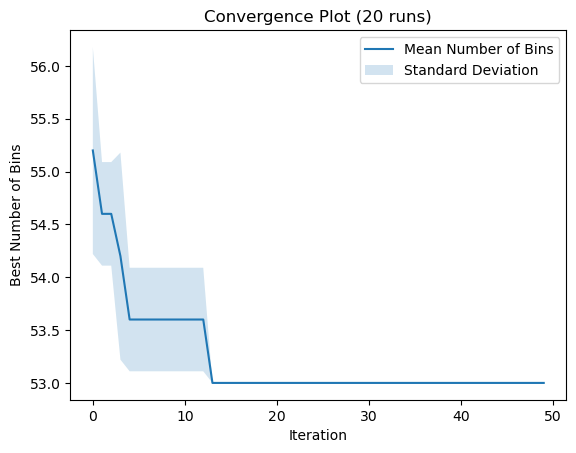

Mean number of unused capacity  872.0
Median number of unused capacity 872.0
Best number of unused capacity 872.0
Worst number of unused capacity 872.0
Standard deviation of unused capacity 0.0


Load Distribution for the best solution
The unused capacity for best solution 872.0


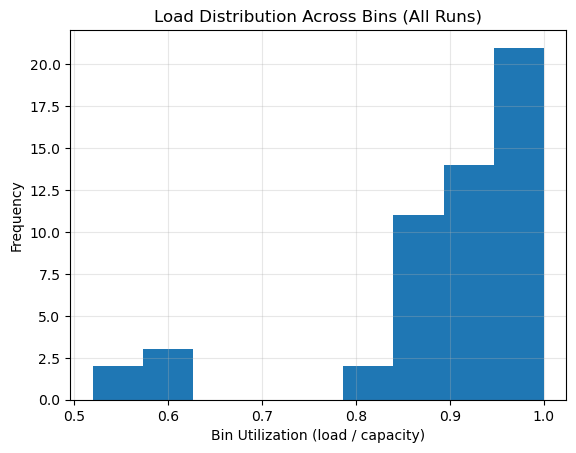

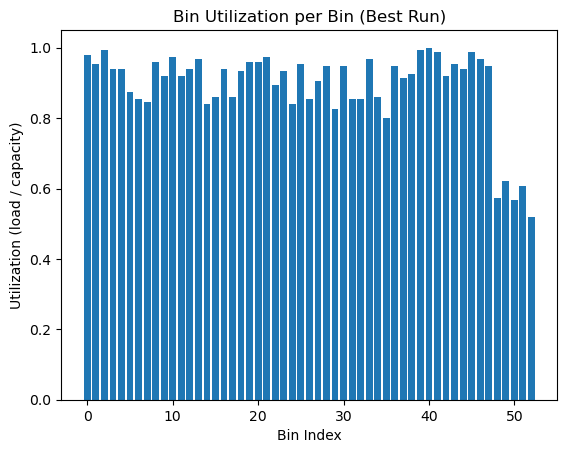

In [43]:
## Increase Ants Number


n_runs = 20 # Number of runs
results = [] # Used for parallel execution

all_runs = [] # Results for each run

with multiprocessing.Pool(processes=pool_size) as pool:
    for run in range(n_runs):
        
        random.seed(run)

        aco = AntColony(num_items=num_items, capacity=capacity, items=item_sizes, n_ants=15, n_best = 5, n_iterations=50, decay = 0.9, alpha = 1, beta = 1)
        res = pool.apply_async(run_aco, (aco,run,))
        results.append(res)
    for result in [res.get() for res in results]:
        run_result = {
            'best_solution': result.all_time_best,
            'best_bins_history': np.array(result.best_bins_history),
            'final_loads': result.final_loads
                                    }
        all_runs.append(run_result)

# Compute Statistics 
# Get final number of bins for each run
final_bins = np.array([run['best_solution'][1] for run in all_runs])
mean_final_bins = np.mean(final_bins) # Mean of final bins
median_final_bins = np.median(final_bins) # Median of final bins
best_final_bins = np.min(final_bins) # Best final bins
worst_final_bins= np.max(final_bins) # Worst final bins
std_dev_final_bins = np.std(final_bins) # Standard deviation 

print("Mean number of final bins", mean_final_bins)
print("Median number of final bins", median_final_bins)
print("Best number of final bins", best_final_bins)
print("Worst number of final bins", worst_final_bins)
print("Standard deviation", std_dev_final_bins)





all_histories_bins = np.array([run['best_bins_history'] for run in all_runs])
mean_histories_bins = np.mean(all_histories_bins, axis=0)
std_histories_bins = np.std(all_histories_bins, axis=0)


plt.plot(mean_histories_bins, label='Mean Number of Bins')
plt.fill_between(range(len(mean_histories_bins)), 
                 mean_histories_bins - std_histories_bins,
                 mean_histories_bins + std_histories_bins,
                 alpha=0.2, label='Standard Deviation')
plt.xlabel('Iteration')
plt.ylabel('Best Number of Bins')
plt.title('Convergence Plot (20 runs)')
plt.legend()
plt.show()


# Get final unused capacity
final_loads = [run['final_loads'] for run in all_runs]
unused_capacity_per_run = [np.sum(capacity - np.array(loads)) for loads in final_loads]
mean_unused = np.mean(unused_capacity_per_run) # Mean of final bins
median_unused = np.median(unused_capacity_per_run) # Median of final bins
best_unused = np.min(unused_capacity_per_run) # Best final bins
worst_unused = np.max(unused_capacity_per_run) # Worst final bins
std_dev_unused = np.std(unused_capacity_per_run) # Standard deviation 

print("Mean number of unused capacity ", mean_unused)
print("Median number of unused capacity", median_unused)
print("Best number of unused capacity", best_unused)
print("Worst number of unused capacity", worst_unused)
print("Standard deviation of unused capacity", std_dev_unused)

print("\n\nLoad Distribution for the best solution")
best_unsed_capacity = []
best_loads = []
for idx, bins in enumerate(final_bins):
    if bins == best_final_bins:
        best_loads = final_loads[idx]
        unused_capacity = np.sum(capacity - np.array(best_loads))
        print("The unused capacity for best solution", unused_capacity)
        plt.hist(np.array(best_loads)/capacity, bins = 'auto')
        plt.xlabel('Bin Utilization (load / capacity)')
        plt.ylabel('Frequency')
        plt.title('Load Distribution Across Bins (All Runs)')
        plt.grid(True, alpha=0.3)
        plt.show()

        plt.bar(range(len(best_loads)), np.array(best_loads)/capacity)
        plt.xlabel('Bin Index')
        plt.ylabel('Utilization (load / capacity)')
        plt.title('Bin Utilization per Bin (Best Run)')
        plt.show()
        break


## Increase Iterations

Mean number of final bins 52.8
Median number of final bins 52.0
Best number of final bins 52
Worst number of final bins 54
Standard deviation 0.9797958971132713


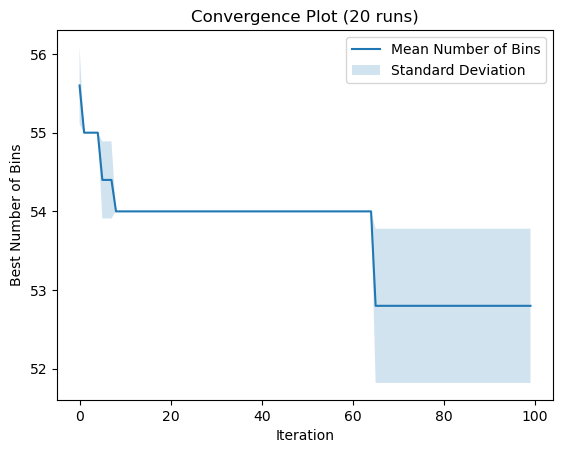

Mean number of unused capacity  842.0
Median number of unused capacity 722.0
Best number of unused capacity 722.0
Worst number of unused capacity 1022.0
Standard deviation of unused capacity 146.9693845669907


Load Distribution for the best solution
The unused capacity for best solution 722.0


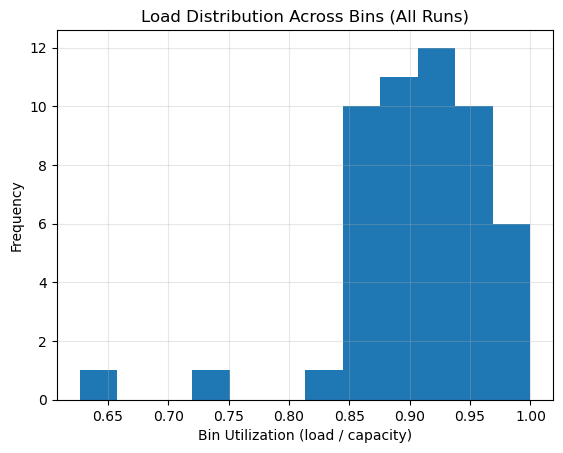

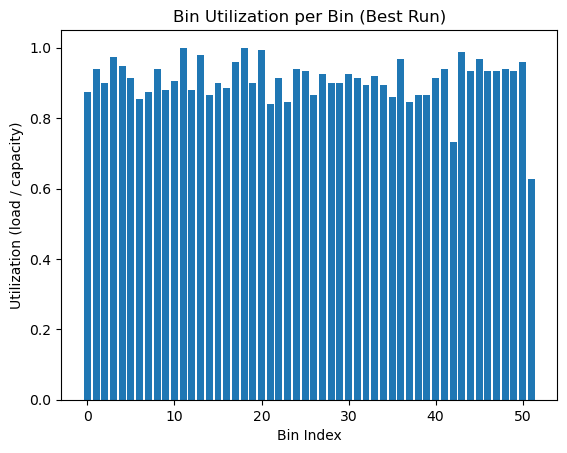

In [45]:
## Increase Ants Number


n_runs = 20 # Number of runs
results = [] # Used for parallel execution

all_runs = [] # Results for each run

with multiprocessing.Pool(processes=pool_size) as pool:
    for run in range(n_runs):
        
        random.seed(run)

        aco = AntColony(num_items=num_items, capacity=capacity, items=item_sizes, n_ants=5, n_best = 5, n_iterations=100, decay = 0.9, alpha = 1, beta = 1)
        res = pool.apply_async(run_aco, (aco,run,))
        results.append(res)
    for result in [res.get() for res in results]:
        run_result = {
            'best_solution': result.all_time_best,
            'best_bins_history': np.array(result.best_bins_history),
            'final_loads': result.final_loads
                                    }
        all_runs.append(run_result)

# Compute Statistics 
# Get final number of bins for each run
final_bins = np.array([run['best_solution'][1] for run in all_runs])
mean_final_bins = np.mean(final_bins) # Mean of final bins
median_final_bins = np.median(final_bins) # Median of final bins
best_final_bins = np.min(final_bins) # Best final bins
worst_final_bins= np.max(final_bins) # Worst final bins
std_dev_final_bins = np.std(final_bins) # Standard deviation 

print("Mean number of final bins", mean_final_bins)
print("Median number of final bins", median_final_bins)
print("Best number of final bins", best_final_bins)
print("Worst number of final bins", worst_final_bins)
print("Standard deviation", std_dev_final_bins)





all_histories_bins = np.array([run['best_bins_history'] for run in all_runs])
mean_histories_bins = np.mean(all_histories_bins, axis=0)
std_histories_bins = np.std(all_histories_bins, axis=0)


plt.plot(mean_histories_bins, label='Mean Number of Bins')
plt.fill_between(range(len(mean_histories_bins)), 
                 mean_histories_bins - std_histories_bins,
                 mean_histories_bins + std_histories_bins,
                 alpha=0.2, label='Standard Deviation')
plt.xlabel('Iteration')
plt.ylabel('Best Number of Bins')
plt.title('Convergence Plot (20 runs)')
plt.legend()
plt.show()


# Get final unused capacity
final_loads = [run['final_loads'] for run in all_runs]
unused_capacity_per_run = [np.sum(capacity - np.array(loads)) for loads in final_loads]
mean_unused = np.mean(unused_capacity_per_run) # Mean of final bins
median_unused = np.median(unused_capacity_per_run) # Median of final bins
best_unused = np.min(unused_capacity_per_run) # Best final bins
worst_unused = np.max(unused_capacity_per_run) # Worst final bins
std_dev_unused = np.std(unused_capacity_per_run) # Standard deviation 

print("Mean number of unused capacity ", mean_unused)
print("Median number of unused capacity", median_unused)
print("Best number of unused capacity", best_unused)
print("Worst number of unused capacity", worst_unused)
print("Standard deviation of unused capacity", std_dev_unused)

print("\n\nLoad Distribution for the best solution")
best_unsed_capacity = []
best_loads = []
for idx, bins in enumerate(final_bins):
    if bins == best_final_bins:
        best_loads = final_loads[idx]
        unused_capacity = np.sum(capacity - np.array(best_loads))
        print("The unused capacity for best solution", unused_capacity)
        plt.hist(np.array(best_loads)/capacity, bins = 'auto')
        plt.xlabel('Bin Utilization (load / capacity)')
        plt.ylabel('Frequency')
        plt.title('Load Distribution Across Bins (All Runs)')
        plt.grid(True, alpha=0.3)
        plt.show()

        plt.bar(range(len(best_loads)), np.array(best_loads)/capacity)
        plt.xlabel('Bin Index')
        plt.ylabel('Utilization (load / capacity)')
        plt.title('Bin Utilization per Bin (Best Run)')
        plt.show()
        break


## Decrease Decay

Mean number of final bins 52.0
Median number of final bins 52.0
Best number of final bins 52
Worst number of final bins 52
Standard deviation 0.0


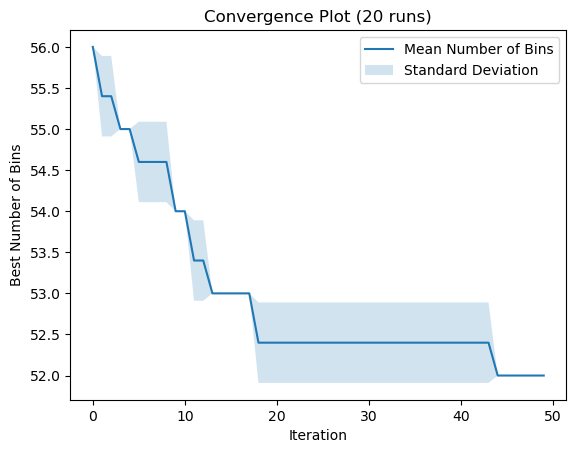

Mean number of unused capacity  722.0
Median number of unused capacity 722.0
Best number of unused capacity 722.0
Worst number of unused capacity 722.0
Standard deviation of unused capacity 0.0


Load Distributiom for the best solution
The unused capacity for best solution 722.0


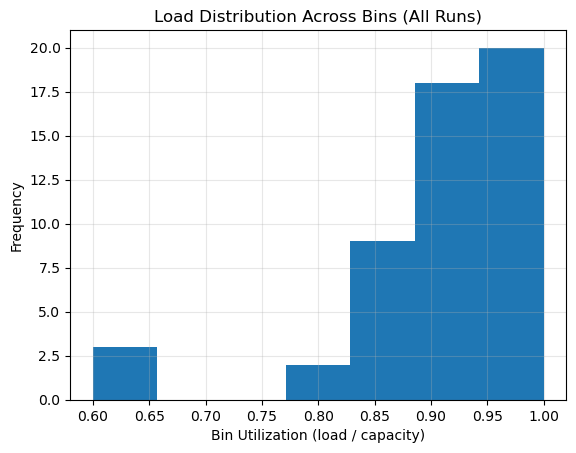

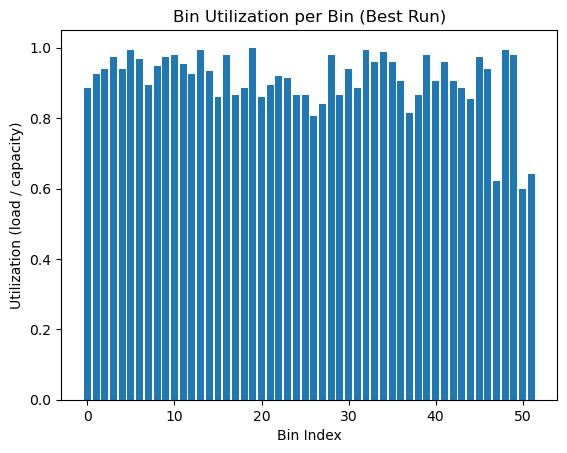

In [46]:

# Aggregate results over 20 runs

n_runs = 20 # Number of runs
results = [] # Used for parallel execution

all_runs = [] # Results for each run

with multiprocessing.Pool(processes=pool_size) as pool:
    for run in range(n_runs):
        
        random.seed(run)

        aco = AntColony(num_items=num_items, capacity=capacity, items=item_sizes, n_ants=5, n_best = 5, n_iterations=50, decay = 0.5, alpha = 1, beta = 1)
        res = pool.apply_async(run_aco, (aco,run,))
        results.append(res)
    for result in [res.get() for res in results]:
        run_result = {
            'best_solution': result.all_time_best,
            'best_bins_history': np.array(result.best_bins_history),
            'final_loads': result.final_loads
                                    }
        all_runs.append(run_result)

# Compute Statistics 
# Get final number of bins for each run
final_bins = np.array([run['best_solution'][1] for run in all_runs])
mean_final_bins = np.mean(final_bins) # Mean of final bins
median_final_bins = np.median(final_bins) # Median of final bins
best_final_bins = np.min(final_bins) # Best final bins
worst_final_bins= np.max(final_bins) # Worst final bins
std_dev_final_bins = np.std(final_bins) # Standard deviation 

print("Mean number of final bins", mean_final_bins)
print("Median number of final bins", median_final_bins)
print("Best number of final bins", best_final_bins)
print("Worst number of final bins", worst_final_bins)
print("Standard deviation", std_dev_final_bins)





all_histories_bins = np.array([run['best_bins_history'] for run in all_runs])
mean_histories_bins = np.mean(all_histories_bins, axis=0)
std_histories_bins = np.std(all_histories_bins, axis=0)


plt.plot(mean_histories_bins, label='Mean Number of Bins')
plt.fill_between(range(len(mean_histories_bins)), 
                 mean_histories_bins - std_histories_bins,
                 mean_histories_bins + std_histories_bins,
                 alpha=0.2, label='Standard Deviation')
plt.xlabel('Iteration')
plt.ylabel('Best Number of Bins')
plt.title('Convergence Plot (20 runs)')
plt.legend()
plt.show()


# Get final unused capacity
final_loads = [run['final_loads'] for run in all_runs]
unused_capacity_per_run = [np.sum(capacity - np.array(loads)) for loads in final_loads]
mean_unused = np.mean(unused_capacity_per_run) # Mean of final bins
median_unused = np.median(unused_capacity_per_run) # Median of final bins
best_unused = np.min(unused_capacity_per_run) # Best final bins
worst_unused = np.max(unused_capacity_per_run) # Worst final bins
std_dev_unused = np.std(unused_capacity_per_run) # Standard deviation 

print("Mean number of unused capacity ", mean_unused)
print("Median number of unused capacity", median_unused)
print("Best number of unused capacity", best_unused)
print("Worst number of unused capacity", worst_unused)
print("Standard deviation of unused capacity", std_dev_unused)

print("\n\nLoad Distributiom for the best solution")


best_unsed_capacity = []
best_loads = []
for idx, bins in enumerate(final_bins):
    if bins == best_final_bins:
        best_loads = final_loads[idx]
        unused_capacity = np.sum(capacity - np.array(best_loads))
        print("The unused capacity for best solution", unused_capacity)
        plt.hist(np.array(best_loads)/capacity, bins = 'auto')
        plt.xlabel('Bin Utilization (load / capacity)')
        plt.ylabel('Frequency')
        plt.title('Load Distribution Across Bins (All Runs)')
        plt.grid(True, alpha=0.3)
        plt.show()

        plt.bar(range(len(best_loads)), np.array(best_loads)/capacity)
        plt.xlabel('Bin Index')
        plt.ylabel('Utilization (load / capacity)')
        plt.title('Bin Utilization per Bin (Best Run)')
        plt.show()
        break


## Modify Alpha

Alpha value is:  0.5
Mean number of final bins 53.0
Median number of final bins 53.0
Best number of final bins 53
Worst number of final bins 53
Standard deviation 0.0


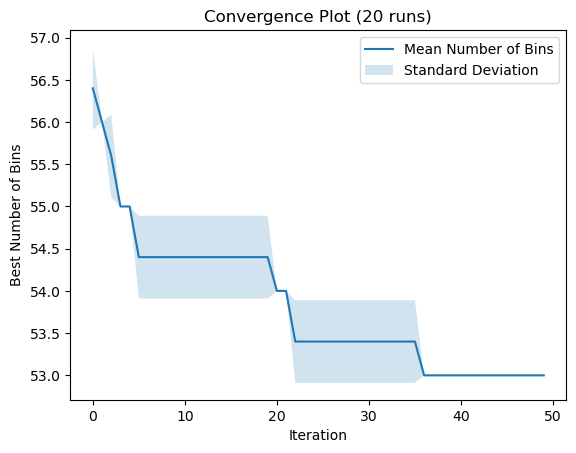

Mean number of unused capacity  872.0
Median number of unused capacity 872.0
Best number of unused capacity 872.0
Worst number of unused capacity 872.0
Standard deviation of unused capacity 0.0


Load Distributiom for the best solution
The unused capacity for best solution 872.0


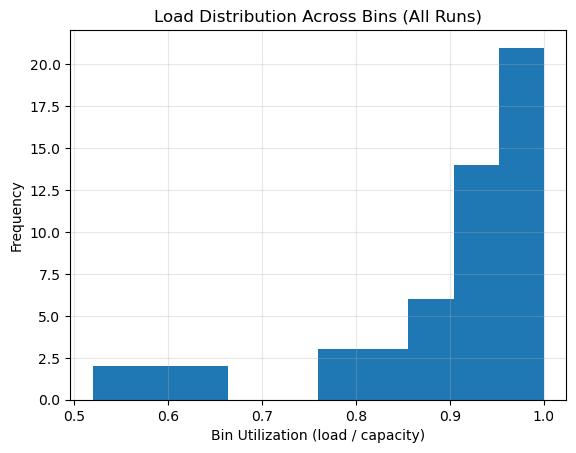

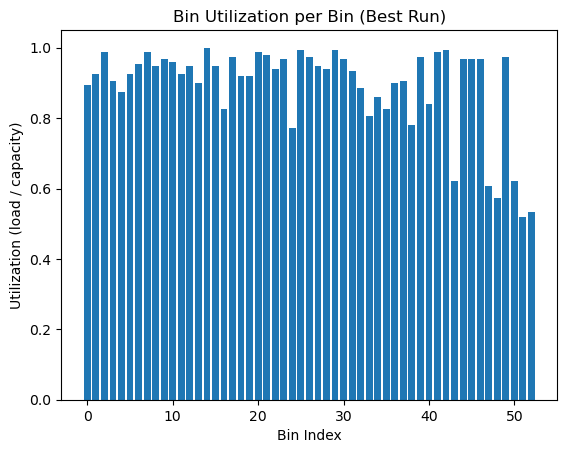

Alpha value is:  2
Mean number of final bins 52.8
Median number of final bins 53.0
Best number of final bins 52
Worst number of final bins 53
Standard deviation 0.4


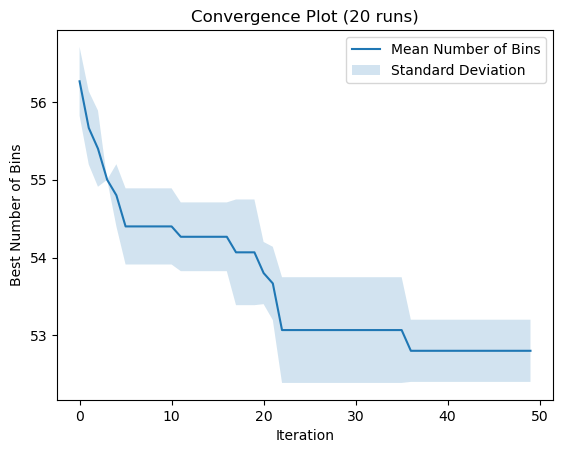

Mean number of unused capacity  842.0
Median number of unused capacity 872.0
Best number of unused capacity 722.0
Worst number of unused capacity 872.0
Standard deviation of unused capacity 60.0


Load Distributiom for the best solution
The unused capacity for best solution 722.0


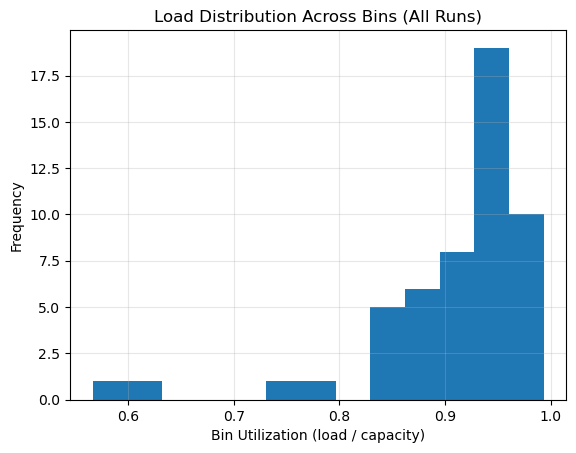

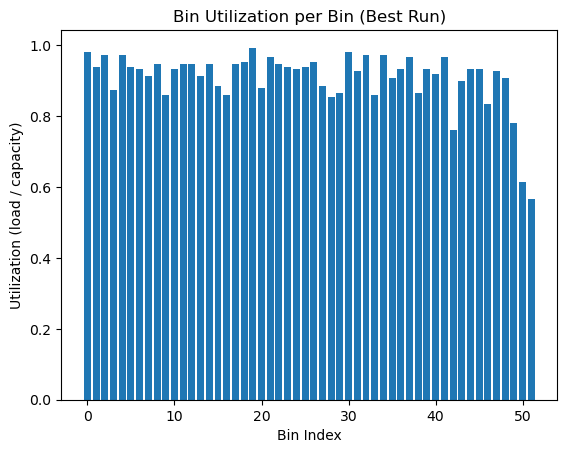

In [48]:

# Aggregate results over 20 runs

n_runs = 20 # Number of runs
results = [] # Used for parallel execution

all_runs = [] # Results for each run

alphas = [0.5, 2]
for alpha in alphas:
    print("Alpha value is: ", alpha)

    with multiprocessing.Pool(processes=pool_size) as pool:
        for run in range(n_runs):
            
            random.seed(run)

            aco = AntColony(num_items=num_items, capacity=capacity, items=item_sizes, n_ants=5, n_best = 5, n_iterations=50, decay = 0.9, alpha = alpha, beta = 1)
            res = pool.apply_async(run_aco, (aco,run,))
            results.append(res)
        for result in [res.get() for res in results]:
            run_result = {
                'best_solution': result.all_time_best,
                'best_bins_history': np.array(result.best_bins_history),
                'final_loads': result.final_loads
                                        }
            all_runs.append(run_result)

    # Compute Statistics 
    # Get final number of bins for each run
    final_bins = np.array([run['best_solution'][1] for run in all_runs])
    mean_final_bins = np.mean(final_bins) # Mean of final bins
    median_final_bins = np.median(final_bins) # Median of final bins
    best_final_bins = np.min(final_bins) # Best final bins
    worst_final_bins= np.max(final_bins) # Worst final bins
    std_dev_final_bins = np.std(final_bins) # Standard deviation 

    print("Mean number of final bins", mean_final_bins)
    print("Median number of final bins", median_final_bins)
    print("Best number of final bins", best_final_bins)
    print("Worst number of final bins", worst_final_bins)
    print("Standard deviation", std_dev_final_bins)





    all_histories_bins = np.array([run['best_bins_history'] for run in all_runs])
    mean_histories_bins = np.mean(all_histories_bins, axis=0)
    std_histories_bins = np.std(all_histories_bins, axis=0)


    plt.plot(mean_histories_bins, label='Mean Number of Bins')
    plt.fill_between(range(len(mean_histories_bins)), 
                    mean_histories_bins - std_histories_bins,
                    mean_histories_bins + std_histories_bins,
                    alpha=0.2, label='Standard Deviation')
    plt.xlabel('Iteration')
    plt.ylabel('Best Number of Bins')
    plt.title('Convergence Plot (20 runs)')
    plt.legend()
    plt.show()


    # Get final unused capacity
    final_loads = [run['final_loads'] for run in all_runs]
    unused_capacity_per_run = [np.sum(capacity - np.array(loads)) for loads in final_loads]
    mean_unused = np.mean(unused_capacity_per_run) # Mean of final bins
    median_unused = np.median(unused_capacity_per_run) # Median of final bins
    best_unused = np.min(unused_capacity_per_run) # Best final bins
    worst_unused = np.max(unused_capacity_per_run) # Worst final bins
    std_dev_unused = np.std(unused_capacity_per_run) # Standard deviation 

    print("Mean number of unused capacity ", mean_unused)
    print("Median number of unused capacity", median_unused)
    print("Best number of unused capacity", best_unused)
    print("Worst number of unused capacity", worst_unused)
    print("Standard deviation of unused capacity", std_dev_unused)

    print("\n\nLoad Distributiom for the best solution")


    best_unsed_capacity = []
    best_loads = []
    for idx, bins in enumerate(final_bins):
        if bins == best_final_bins:
            best_loads = final_loads[idx]
            unused_capacity = np.sum(capacity - np.array(best_loads))
            print("The unused capacity for best solution", unused_capacity)
            plt.hist(np.array(best_loads)/capacity, bins = 'auto')
            plt.xlabel('Bin Utilization (load / capacity)')
            plt.ylabel('Frequency')
            plt.title('Load Distribution Across Bins (All Runs)')
            plt.grid(True, alpha=0.3)
            plt.show()

            plt.bar(range(len(best_loads)), np.array(best_loads)/capacity)
            plt.xlabel('Bin Index')
            plt.ylabel('Utilization (load / capacity)')
            plt.title('Bin Utilization per Bin (Best Run)')
            plt.show()
            break


# Modify Beta

Beta value is:  0.5
Mean number of final bins 52.0
Median number of final bins 52.0
Best number of final bins 52
Worst number of final bins 52
Standard deviation 0.0


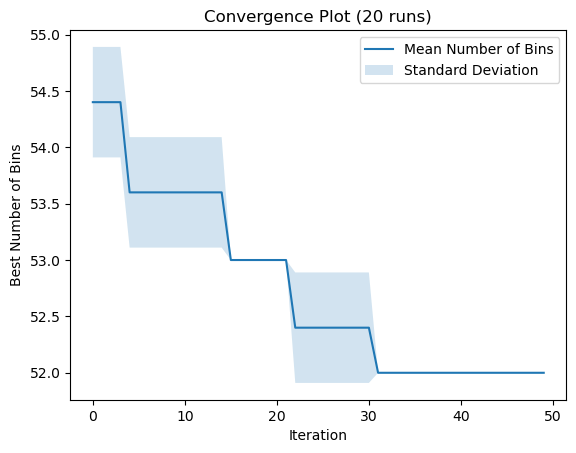

Mean number of unused capacity  722.0
Median number of unused capacity 722.0
Best number of unused capacity 722.0
Worst number of unused capacity 722.0
Standard deviation of unused capacity 0.0


Load Distributiom for the best solution
The unused capacity for best solution 722.0


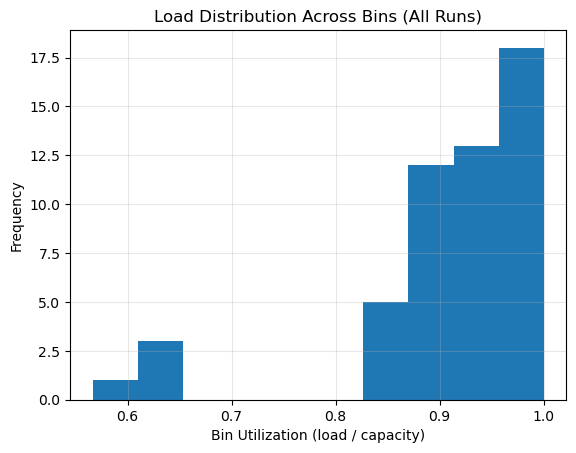

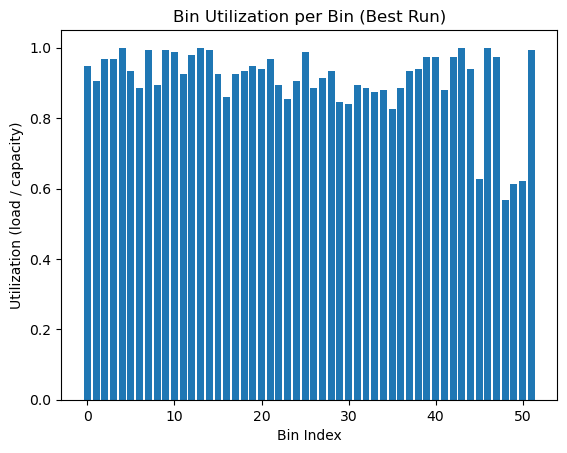

Beta value is:  2
Mean number of final bins 52.86666666666667
Median number of final bins 52.0
Best number of final bins 52
Worst number of final bins 55
Standard deviation 1.2578641509408806


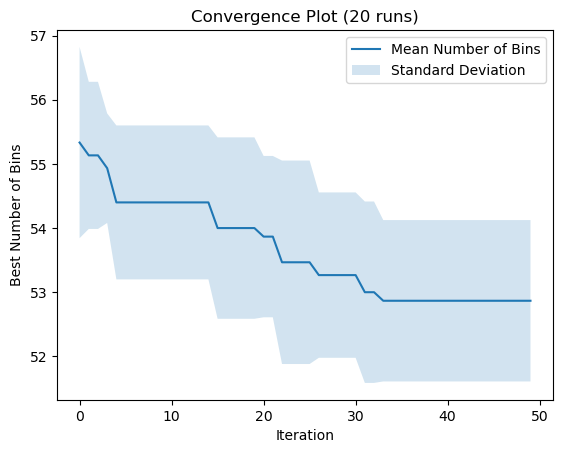

Mean number of unused capacity  852.0
Median number of unused capacity 722.0
Best number of unused capacity 722.0
Worst number of unused capacity 1172.0
Standard deviation of unused capacity 188.67962264113208


Load Distributiom for the best solution
The unused capacity for best solution 722.0


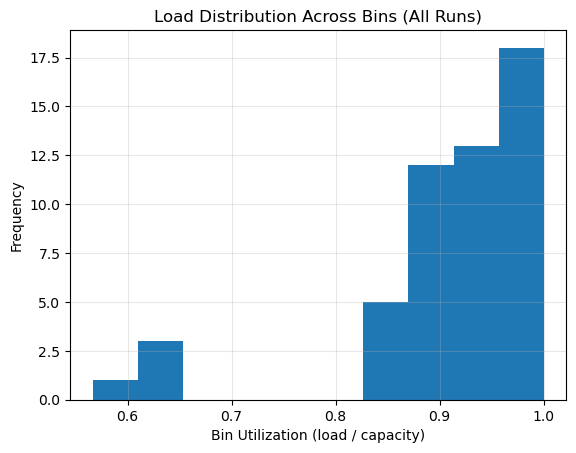

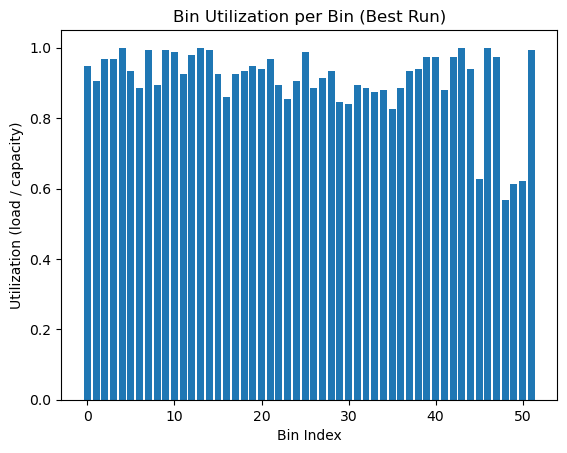

In [50]:

# Aggregate results over 20 runs

n_runs = 20 # Number of runs
results = [] # Used for parallel execution

all_runs = [] # Results for each run

betas = [0.5, 2]
for beta in betas:
    print("Beta value is: ", beta)

    with multiprocessing.Pool(processes=pool_size) as pool:
        for run in range(n_runs):
            
            random.seed(run)

            aco = AntColony(num_items=num_items, capacity=capacity, items=item_sizes, n_ants=5, n_best = 5, n_iterations=50, decay = 0.9, alpha = 1, beta = beta)
            res = pool.apply_async(run_aco, (aco,run,))
            results.append(res)
        for result in [res.get() for res in results]:
            run_result = {
                'best_solution': result.all_time_best,
                'best_bins_history': np.array(result.best_bins_history),
                'final_loads': result.final_loads
                                        }
            all_runs.append(run_result)

    # Compute Statistics 
    # Get final number of bins for each run
    final_bins = np.array([run['best_solution'][1] for run in all_runs])
    mean_final_bins = np.mean(final_bins) # Mean of final bins
    median_final_bins = np.median(final_bins) # Median of final bins
    best_final_bins = np.min(final_bins) # Best final bins
    worst_final_bins= np.max(final_bins) # Worst final bins
    std_dev_final_bins = np.std(final_bins) # Standard deviation 

    print("Mean number of final bins", mean_final_bins)
    print("Median number of final bins", median_final_bins)
    print("Best number of final bins", best_final_bins)
    print("Worst number of final bins", worst_final_bins)
    print("Standard deviation", std_dev_final_bins)





    all_histories_bins = np.array([run['best_bins_history'] for run in all_runs])
    mean_histories_bins = np.mean(all_histories_bins, axis=0)
    std_histories_bins = np.std(all_histories_bins, axis=0)


    plt.plot(mean_histories_bins, label='Mean Number of Bins')
    plt.fill_between(range(len(mean_histories_bins)), 
                    mean_histories_bins - std_histories_bins,
                    mean_histories_bins + std_histories_bins,
                    alpha=0.2, label='Standard Deviation')
    plt.xlabel('Iteration')
    plt.ylabel('Best Number of Bins')
    plt.title('Convergence Plot (20 runs)')
    plt.legend()
    plt.show()


    # Get final unused capacity
    final_loads = [run['final_loads'] for run in all_runs]
    unused_capacity_per_run = [np.sum(capacity - np.array(loads)) for loads in final_loads]
    mean_unused = np.mean(unused_capacity_per_run) # Mean of final bins
    median_unused = np.median(unused_capacity_per_run) # Median of final bins
    best_unused = np.min(unused_capacity_per_run) # Best final bins
    worst_unused = np.max(unused_capacity_per_run) # Worst final bins
    std_dev_unused = np.std(unused_capacity_per_run) # Standard deviation 

    print("Mean number of unused capacity ", mean_unused)
    print("Median number of unused capacity", median_unused)
    print("Best number of unused capacity", best_unused)
    print("Worst number of unused capacity", worst_unused)
    print("Standard deviation of unused capacity", std_dev_unused)

    print("\n\nLoad Distributiom for the best solution")


    best_unsed_capacity = []
    best_loads = []
    for idx, bins in enumerate(final_bins):
        if bins == best_final_bins:
            best_loads = final_loads[idx]
            unused_capacity = np.sum(capacity - np.array(best_loads))
            print("The unused capacity for best solution", unused_capacity)
            plt.hist(np.array(best_loads)/capacity, bins = 'auto')
            plt.xlabel('Bin Utilization (load / capacity)')
            plt.ylabel('Frequency')
            plt.title('Load Distribution Across Bins (All Runs)')
            plt.grid(True, alpha=0.3)
            plt.show()

            plt.bar(range(len(best_loads)), np.array(best_loads)/capacity)
            plt.xlabel('Bin Index')
            plt.ylabel('Utilization (load / capacity)')
            plt.title('Bin Utilization per Bin (Best Run)')
            plt.show()
            break


# Problem #2

In [51]:
# Get the data


filename = "Data/1-D Bin Packing /binpack2.txt"

problems = read_binpack_file(filename)

## Select one problem from the instance

first_problem_key = list(problems.keys())[1]

capacity = problems[first_problem_key]["bin_capacity"]
num_items = problems[first_problem_key]["num_items"]
item_sizes = problems[first_problem_key]["item_sizes"]

print("Capacity: ", capacity)
print("Number of items: ", num_items)

Capacity:  150
Number of items:  250


Mean number of final bins 113.4
Median number of final bins 113.0
Best number of final bins 113
Worst number of final bins 114
Standard deviation 0.4898979485566356


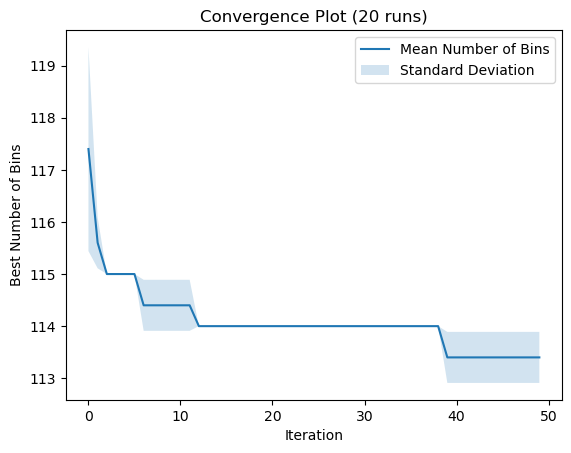

Mean number of unused capacity  2156.0
Median number of unused capacity 2096.0
Best number of unused capacity 2096.0
Worst number of unused capacity 2246.0
Standard deviation of unused capacity 73.48469228349535


Load Distributiom for the best solution
The unused capacity for best solution 2096.0


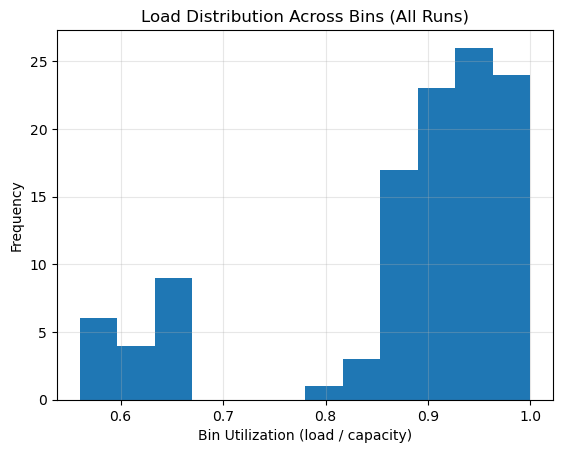

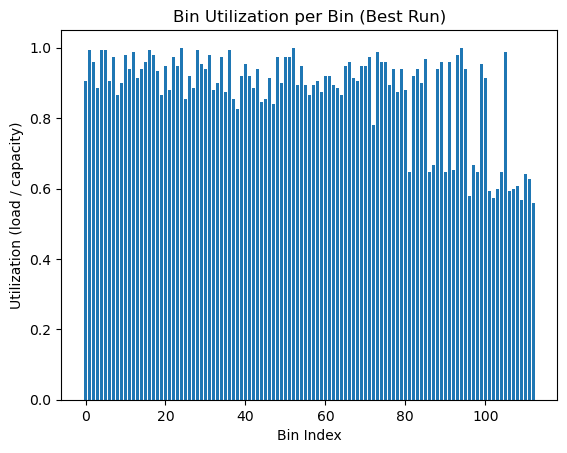

In [52]:

# Aggregate results over 20 runs

n_runs = 20 # Number of runs
results = [] # Used for parallel execution

all_runs = [] # Results for each run

with multiprocessing.Pool(processes=pool_size) as pool:
    for run in range(n_runs):
        
        random.seed(run)

        aco = AntColony(num_items=num_items, capacity=capacity, items=item_sizes, n_ants=5, n_best = 5, n_iterations=50, decay = 0.9, alpha = 1, beta = 1)
        res = pool.apply_async(run_aco, (aco,run,))
        results.append(res)
    for result in [res.get() for res in results]:
        run_result = {
            'best_solution': result.all_time_best,
            'best_bins_history': np.array(result.best_bins_history),
            'final_loads': result.final_loads
                                    }
        all_runs.append(run_result)

# Compute Statistics 
# Get final number of bins for each run
final_bins = np.array([run['best_solution'][1] for run in all_runs])
mean_final_bins = np.mean(final_bins) # Mean of final bins
median_final_bins = np.median(final_bins) # Median of final bins
best_final_bins = np.min(final_bins) # Best final bins
worst_final_bins= np.max(final_bins) # Worst final bins
std_dev_final_bins = np.std(final_bins) # Standard deviation 

print("Mean number of final bins", mean_final_bins)
print("Median number of final bins", median_final_bins)
print("Best number of final bins", best_final_bins)
print("Worst number of final bins", worst_final_bins)
print("Standard deviation", std_dev_final_bins)





all_histories_bins = np.array([run['best_bins_history'] for run in all_runs])
mean_histories_bins = np.mean(all_histories_bins, axis=0)
std_histories_bins = np.std(all_histories_bins, axis=0)


plt.plot(mean_histories_bins, label='Mean Number of Bins')
plt.fill_between(range(len(mean_histories_bins)), 
                 mean_histories_bins - std_histories_bins,
                 mean_histories_bins + std_histories_bins,
                 alpha=0.2, label='Standard Deviation')
plt.xlabel('Iteration')
plt.ylabel('Best Number of Bins')
plt.title('Convergence Plot (20 runs)')
plt.legend()
plt.show()


# Get final unused capacity
final_loads = [run['final_loads'] for run in all_runs]
unused_capacity_per_run = [np.sum(capacity - np.array(loads)) for loads in final_loads]
mean_unused = np.mean(unused_capacity_per_run) # Mean of final bins
median_unused = np.median(unused_capacity_per_run) # Median of final bins
best_unused = np.min(unused_capacity_per_run) # Best final bins
worst_unused = np.max(unused_capacity_per_run) # Worst final bins
std_dev_unused = np.std(unused_capacity_per_run) # Standard deviation 

print("Mean number of unused capacity ", mean_unused)
print("Median number of unused capacity", median_unused)
print("Best number of unused capacity", best_unused)
print("Worst number of unused capacity", worst_unused)
print("Standard deviation of unused capacity", std_dev_unused)

print("\n\nLoad Distributiom for the best solution")


best_unsed_capacity = []
best_loads = []
for idx, bins in enumerate(final_bins):
    if bins == best_final_bins:
        best_loads = final_loads[idx]
        unused_capacity = np.sum(capacity - np.array(best_loads))
        print("The unused capacity for best solution", unused_capacity)
        plt.hist(np.array(best_loads)/capacity, bins = 'auto')
        plt.xlabel('Bin Utilization (load / capacity)')
        plt.ylabel('Frequency')
        plt.title('Load Distribution Across Bins (All Runs)')
        plt.grid(True, alpha=0.3)
        plt.show()

        plt.bar(range(len(best_loads)), np.array(best_loads)/capacity)
        plt.xlabel('Bin Index')
        plt.ylabel('Utilization (load / capacity)')
        plt.title('Bin Utilization per Bin (Best Run)')
        plt.show()
        break
